# Notebook to test solutions for issues with wingbeat frequency calculation, particularly occuring with Drosophila

To keep the harmonics from causing issues, I've added a species-specific frequency maximum. This may do the trick, but regardless I want to add in detection for periods of non-flight

## Imports

In [295]:
import os 
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from mosquito.process_abf import load_processed_data
from mosquito.util import idx_by_thresh, butter_bandpass_filter

## Params

In [296]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

In [297]:
# current color cycle
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#8dd3c7', '#feffb3', '#bfbbd9', '#fa8174', '#81b1d2', '#fdb462', '#b3de69', '#bc82bd', '#ccebc4', '#ffed6f']


## Load data

In [298]:
# load data from file
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '18_20240508'  # '21_20240515'  #   
axo_num = 4  #6  #   
# vid_str = 'aedes_C001H001S0001_20240326_154951'

data = load_processed_data(data_folder, axo_num)

In [299]:
# read out some data
t = data['time']
fs = data['sampling_freq']
wbf = data['wbf'] 
mic = data['mic']
emg_filt = data['emg_filt']


In [300]:
# re-filter microphone (if drosophila)
mic_filt = butter_bandpass_filter(mic, 100, 300, (1/fs))


## Look at periods of stopped flight

Text(0, 0.5, 'mic (filtered)')

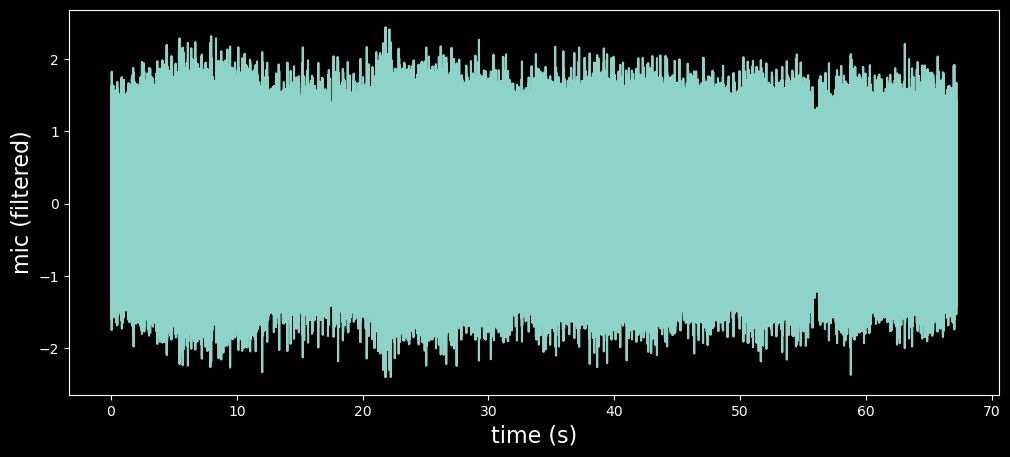

In [301]:
# quick visualization of signal
fig, ax = plt.subplots(figsize=(12,5))

tmin = 0
tmax = 150
mask = (t >= tmin) & (t <= tmax)

ax.plot(t[mask], mic_filt[mask])
ax.set_xlabel('time (s)')
ax.set_ylabel('mic (filtered)')

In [302]:
# calculate amplitude envelope
analytic_mic = signal.hilbert(mic_filt)
amplitude_envelope = np.abs(analytic_mic)


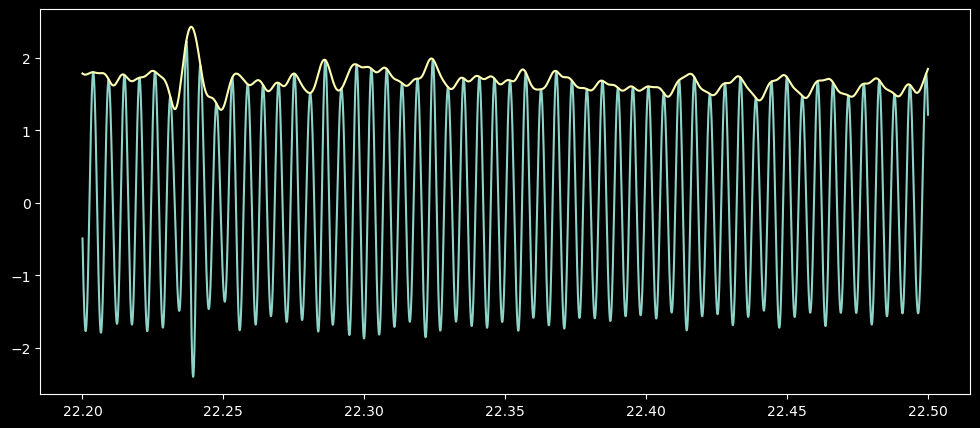

In [303]:
# visualize envelope
fig, ax = plt.subplots(figsize=(12,5))

tmin = 22.2
tmax = 22.5
mask = (t >= tmin) & (t <= tmax)

ax.plot(t[mask], mic_filt[mask])
ax.plot(t[mask], amplitude_envelope[mask])

In [304]:
# filter the envelope signal
# from mosquito.util import butter_lowpass_filter
# envelope_filt = butter_lowpass_filter(amplitude_envelope, 5, (1/fs))

amplitude_envelope_series = pd.Series(amplitude_envelope)
envelope_filt = amplitude_envelope_series.rolling(window=501, center=True).max()
envelope_filt = envelope_filt.rolling(window=501, center=True).median()
envelope_filt.ffill(inplace=True)
envelope_filt.bfill(inplace=True)


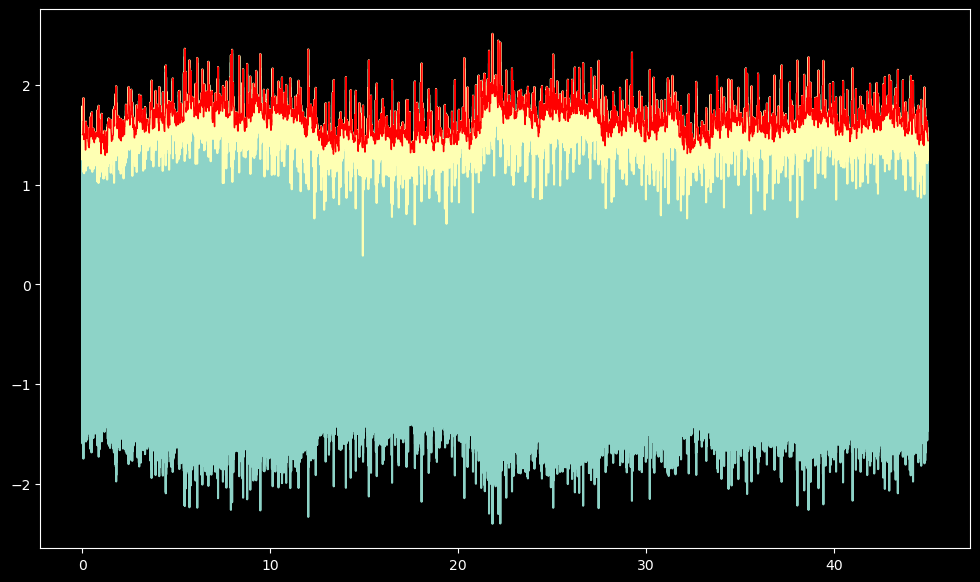

In [305]:
# visualize the filtered signal
fig, ax0 = plt.subplots(figsize=(12,7))

tmin = 0  # 21
tmax = 45 # 23
mask = (t >= tmin) & (t <= tmax)

ax0.plot(t[mask], mic_filt[mask])
ax0.plot(t[mask], amplitude_envelope[mask])
# ax0.plot(t[mask], envelope_filt[mask], 'r')
ax0.plot(t[mask], envelope_filt[mask], 'r', lw=1)

# ax1.plot(t[mask], emg_filt[mask])

In [306]:
# use lowpass-filtered amplitude to determine non-flying regions of the time series?
env_filt_median = np.nanmedian(envelope_filt)
env_filt_mad = np.nanmedian(np.abs(env_filt_median - envelope_filt))
stop_thresh_lower = (env_filt_median - 4*env_filt_mad)
stop_thresh_upper = (env_filt_median + 20*env_filt_mad)
flying_idx = (envelope_filt > stop_thresh_lower) & (envelope_filt < stop_thresh_upper)
flying_idx.values

array([ True,  True,  True, ...,  True,  True,  True])

In [307]:
stop_thresh_lower

1.1954981409318048

Text(0.5, 1.0, 'Flight bouts')

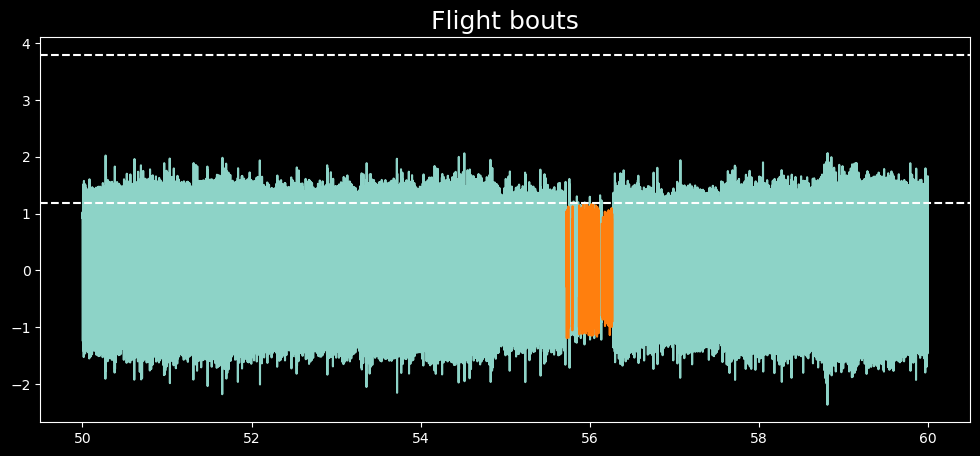

In [311]:
fig, ax = plt.subplots(figsize=(12,5))

tmin = 50
tmax = 60
mask = (t >= tmin) & (t <= tmax)

mic_filt_flying = mic_filt.copy()
mic_filt_flying[~flying_idx] = np.nan

mic_filt_not_flying = mic_filt.copy()
mic_filt_not_flying[flying_idx] = np.nan

ax.plot(t[mask], mic_filt_flying[mask])
ax.plot(t[mask], mic_filt_not_flying[mask], 'tab:orange')
# ax.plot(t[mask], envelope_filt[mask], 'm')
ax.axhline(stop_thresh_lower, color='w', ls='--')
ax.axhline(stop_thresh_upper, color='w', ls='--')
# ax.plot(t[mask], stopped_idx[mask], 'w')

ax.set_title('Flight bouts')

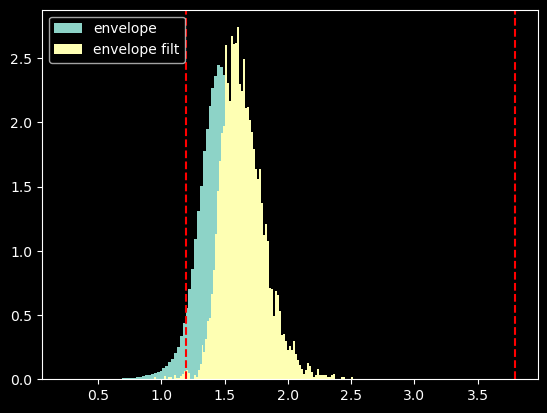

In [309]:
# look at distribution of amplitude envelope
fig, ax = plt.subplots()
ax.hist(amplitude_envelope, bins=100, density=True, label='envelope')
ax.hist(envelope_filt, bins=100, density=True, label='envelope filt')
ax.axvline(stop_thresh_lower, color='r', ls='--')
ax.axvline(stop_thresh_upper, color='r', ls='--')
plt.legend()

IndexError: Boolean index has wrong length: 2358272 instead of 5593536

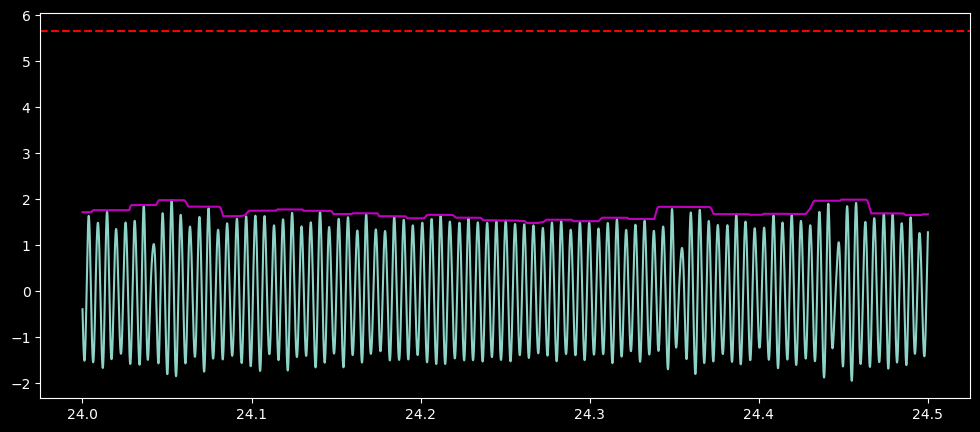

In [310]:
# visualize

fig, ax = plt.subplots(figsize=(12,5))

tmin = 24
tmax = 24.5
mask = (t >= tmin) & (t <= tmax)

ax.plot(t[mask], mic_filt[mask])
ax.plot(t[mask], envelope_filt[mask], 'm')
ax.axhline(blow_thresh, color='r', ls='--')
ax.plot(t[mask], blow_idx[mask], 'w')

## Merge/split detected periods of stopped flight

In [ ]:
# get periods of stopped flight in a list
flight_bouts = idx_by_thresh(flying_idx)

bout_lengths = [(1/fs)*len(bout) for bout in flight_bouts] 
bout_lengths

In [ ]:
fs*0.5

In [ ]:
stop_bouts = idx_by_thresh(~flying_idx)
stop_bout_lengths = [(1/fs)*len(bout) for bout in stop_bouts] 
stop_bout_lengths